# Amazon Product Review Sentiment Analysis

This notebook uses customer reviews scraped from an Amazon food product to determine the consumer preferences for each flavour of the product.

The data is sourced from the reviews.json file output from the scraper notebook in this repo.

## Imports

In [220]:
import pandas as pd
from matplotlib import pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from googletrans import Translator
import re
import seaborn as sns

## EDA

In [168]:
# Verified purchaser Amazon reviews on Pure Protein Bar last updated: 2023-02-24
df = pd.read_json("reviews.json")
print(df.shape)

(2089, 5)


In [169]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2089 entries, 0 to 2088
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       2089 non-null   object
 1   foreign  2089 non-null   bool  
 2   title    2089 non-null   object
 3   flavour  2089 non-null   object
 4   content  2089 non-null   object
dtypes: bool(1), object(4)
memory usage: 67.4+ KB
None


In [170]:
# what flavours are in the dataset
print(df['flavour'].unique())

['Chocolate Deluxe' 'Dark Chocolate Coconut'
 'Strawberry with Greek Yogurt' 'Chocolate Salted Caramel'
 'Chocolate Peanut Butter' 'Chocolate Peanut Caramel'
 'Chewy Chocolate Chip']


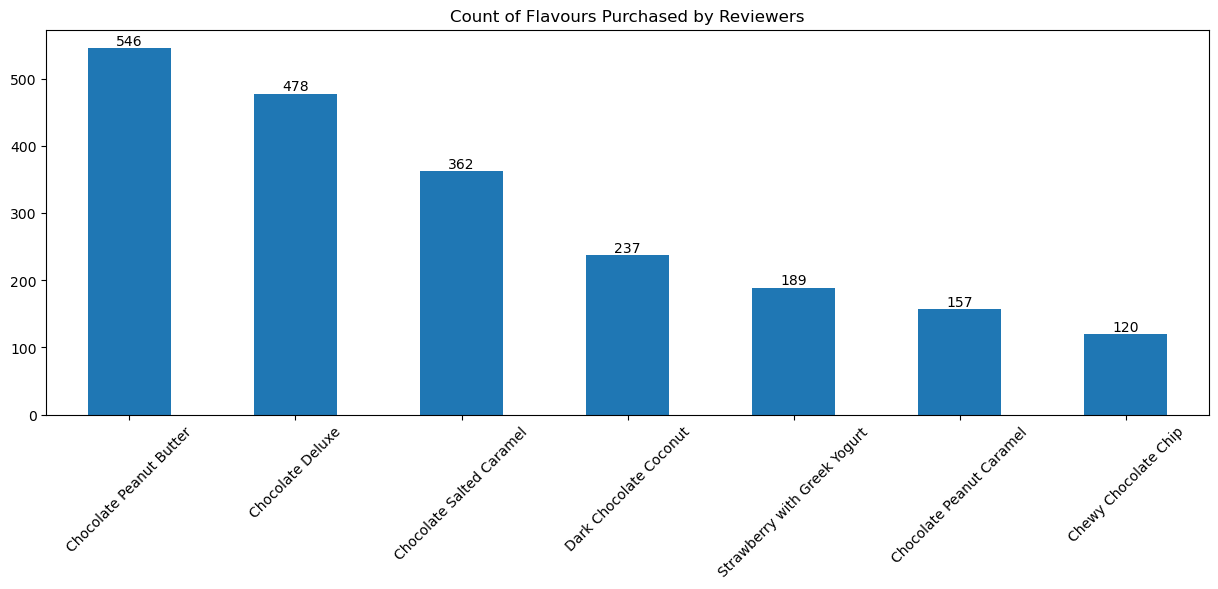

In [171]:
# flavour count
ax = df['flavour'].value_counts().plot(kind='bar',title="Count of Flavours Purchased by Reviewers", figsize=(15,5))
for bars in ax.containers: # bar counts
    ax.bar_label(bars)
plt.xticks(rotation=45)
plt.show()


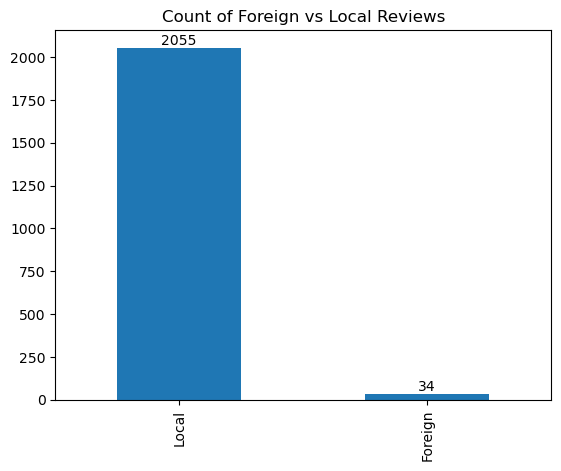

In [172]:
# foreign vs local review count
ax = df['foreign'].value_counts().plot(kind='bar',title="Count of Foreign vs Local Reviews")
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['Local' if x=='False' else 'Foreign' for x in labels] #rename labels
ax.set_xticklabels(labels)

# add count values
for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

## Data Preprocessing

1. Exclude reviews from foreign countries as foreign customers may receive a different product/service. The count of foreign reviews in this case is low compared to local and won't significantly affect sample size.
2. Remove line breaks from reviews
3. Translate reviews to English.


In [173]:
# drop foreign reviews
df.drop(df[df['foreign']==True].index,inplace=True)
print(df.shape)

(2055, 5)


In [174]:
# remove linebreaks
df['content'] = df['content'].apply(lambda x : re.sub(r"\n"," ",x))
df['title'] = df['title'].apply(lambda x: re.sub(r"\n"," ", x))

In [175]:
# handle non-english reviews
# translate to english
translator = Translator()
df['content_eng'] = df['content'].apply(lambda x: translator.translate(x).text)
df['title_eng'] = df['title'].apply(lambda x: translator.translate(x).text)

## Sentiment Analysis


In [176]:
# initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [177]:
def get_sent(text):
    return sia.polarity_scores(text)['compound']

In [178]:
# run sia on each review and store in a column
# include title since that contains relevant consumer opinion information

df['temp'] = df['title_eng']+' '+ df['content_eng']
df['score'] = df['temp'].apply(lambda x: get_sent(x))
df.drop(labels="temp",inplace=True,axis=1)


In [218]:
# check an example
ex = df[['content_eng','score']].sample(1)
display(ex.content_eng.values[0])
print("Score:",ex.score.values[0])

'The taste of protein bars is a hit or miss. They can taste a little dry and chalky. These are the exact opposite. I ordered the peanut butter chocolate and was pleasantly surprised. The value is great as most protein bars are over $3. Definitely would buy again'

Score: 0.9501


## Results

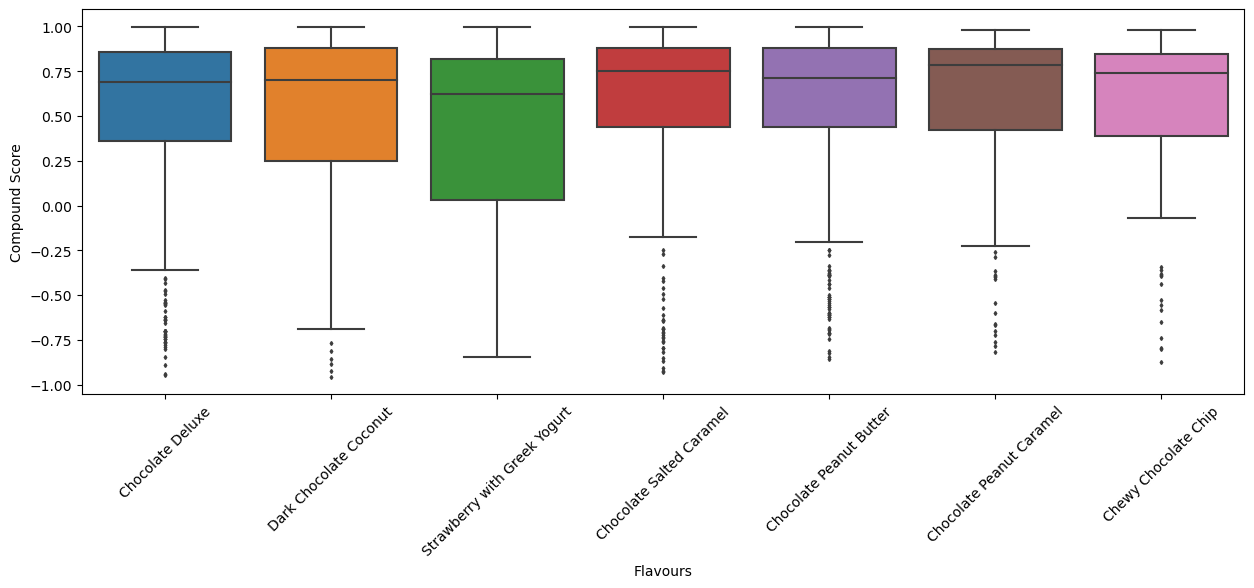

In [230]:
# boxplots of compound scores by flavour
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.boxplot(data=df, y='score', x='flavour',fliersize=2,ax=ax)
ax.tick_params(axis='x',rotation=45)
ax.set_xlabel("Flavours")
ax.set_ylabel("Compound Score")
plt.show()


By comparing medians, it looks like Chocolate Peanut Caramel is the preferred flavour for this protein bar and Strawberry with Greek Yogurt is the least preferred flavour; not very surprising. We can also take a look at the reviews with the highest and lowest sentiment scores for these two flavours.

In [241]:
max_id = df[df['flavour']=='Chocolate Peanut Caramel'].loc[:,'score'].idxmax()
min_id = df[df['flavour']=='Chocolate Peanut Caramel'].loc[:,'score'].idxmin()

# most positive
print("Flavour:",df.iloc[max_id]['flavour'],'\n')
print("Maximum Score:",df.iloc[max_id]['score'])
print(df.iloc[max_id]['content_eng'])
# most negative
print("Minimum Score:",df.iloc[min_id]['score'])
print(df.iloc[min_id]['content_eng'])

max_id = df[df['flavour']=='Strawberry with Greek Yogurt'].loc[:,'score'].idxmax()
min_id = df[df['flavour']=='Strawberry with Greek Yogurt'].loc[:,'score'].idxmin()

# most positive
print("\nFlavour:",df.iloc[max_id]['flavour'],'\n')
print("Maximum Score:",df.iloc[max_id]['score'])
print(df.iloc[max_id]['content_eng'])
# most negative
print("Minimum Score:",df.iloc[min_id]['score'])
print(df.iloc[min_id]['content_eng'])



Flavour: Chocolate Peanut Caramel 

Maximum Score: 0.9818
These are delicious. I used to get tons of them until I found a protein powder I could tolerate. Definitely recommend having these instead of chocolate bars for anyone trying to slim down. Writing this review is actually giving me a craving for one now, lol. Best price is here, cheaper than at my local Walmart.
Minimum Score: -0.8176
Arrived damaged and crushed

Flavour: Strawberry with Greek Yogurt 

Maximum Score: 0.9997
These Pure Protein bars are great! Cheap and yummy. They're more dense than other bars such as Quest bars. So even though they're smaller in size they're actually quite hearty because of being so dense and I'm definitely satisfied after eating one no matter what flavour.  The chocolate peanut caramel one is a tad softer & less dense than the others because of the softer peanut flavoured center. The chocolate peanut caramel flavour is one of my husband's favorite and reminds us of a snickers or mars bar. Its si

Here we can see a limitation of this method in that the most negative review of the Chocolate Peanut Caramel bars is related to the packaging and not the flavour of the protein bar. It may be best to filter reviews containing words related to taste, flavour and consistency in the future. Also, finding the best flavour to try would've been a whole lot easier if I found the review with the highest sentiment for Strawberry with Greek Yogurt at first...

However, acknowledging that limitation, it seems like either caramel flavour are the best bet or Chewy Chocolate Chip due its low score variance.